In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from core.data.data_utils import *

# Nonlinear Regression

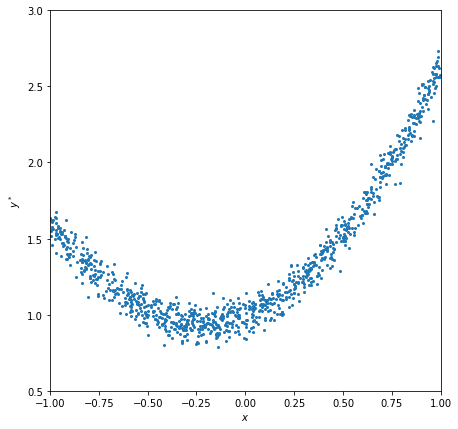

Data shape: (1000, 2)


In [2]:
data = generate_data_for_regression(num_points=1000) # Generates 1000 (x,y*) points
print('Data shape:', data.shape)

## Coding a Neural Network
Example: train a neural network with one hidden layer with sigmoid activation functions to approximate the nonlinear function depicted in the figure.

In [3]:
class Neural_Network():
    def __init__(self, n1=10):        
        self.input_dim = 1                 # Input dimension
        self.output_dim = 1                # Output dimension
        self.learning_rate = 0.1           # Learning rate for SGD
        
        self.n1 = n1                       # Number of neurons in the first layer
        self.n2 = self.output_dim          # Number of neurons in the second layer
        
        self.W1 = np.random.normal(loc=0, scale=0.01, size=(self.n1, self.input_dim))  # Weights of the first layer
        self.b1 = np.zeros((self.n1, 1))                                               # Biases of the first layer
        self.W2 = np.random.normal(loc=0, scale=0.01, size=(self.n2, self.n1))         # Weights of the second layer
        self.b2 = np.zeros((self.n2, 1))                                               # Biases of the second layer
        
    def loss(self, y, y_star, compute_derivative=False):
        l = 0.5*(y_star - y)**2        # Mean squared error criterion
        dldy = 0                       # Default derivative
        if(compute_derivative):
            dldy = -(y_star - y)       # Derivative computation
        return l, dldy

    def f2(self, q, compute_derivative=False): # Activation function of layer 2
        y = q                                  # Linear function
        dydq = 0                               # Default derivative
        if(compute_derivative):
            dydq = np.ones_like(q)             # Derivative computation
        return y, dydq
        
    def f1(self, q, compute_derivative=False): # Activation function of layer 1
        y = 1/(1 + np.exp(-q))                 # Sigmoid function
        dydq = 0                               # Default derivative
        if(compute_derivative):
            dydq = y*(1 - y)                   # Derivative computation
        return y, dydq

    def forward_pass(self, X, track_derivatives=False):     # track_derivatives must be True when training
        self.X_in = X.reshape(self.input_dim, -1)           # Check shape
        self.ones_batch = np.ones((self.X_in.shape[1], 1))  # Column vector of ones with the size of the input batch
        
        Q1 = np.dot(self.W1, self.X_in) + np.dot(self.b1, self.ones_batch.T)      # Linear combination in first layer 
        self.Y1, self.dY1dQ1 = self.f1(Q1, compute_derivative=track_derivatives)  # Output of the first layer
        
        Q2 = np.dot(self.W2, self.Y1) + np.dot(self.b2, self.ones_batch.T)        # Linear combination in second layer 
        self.Y2, self.dY2dQ2 = self.f2(Q2, compute_derivative=track_derivatives)  # Output of the second layer
        
        return self.Y2.copy() # Return the output of the network
        
    def compute_loss(self, Y, Y_star, track_derivatives=False): # track_derivatives must be True when training
        Y_in = Y.reshape(self.output_dim, -1)                   # Check shape
        Y_star_in = Y_star.reshape(self.output_dim, -1)         # Check shape
        
        L, self.dLdY2 = self.loss(Y_in, Y_star_in, compute_derivative=track_derivatives) # Loss computation
        return L.sum(1) # Return the cumulative loss of the batch of data
    
    def backward_pass(self):             # Must be called after forward_pass() and compute_loss()
        Phi2 = self.dLdY2 * self.dY2dQ2  # Compute the Phi2 matrix      
        dLdY1 = np.dot(self.W2.T, Phi2)  # Compute the dLdY1 matrix
        Phi1 = dLdY1 * self.dY1dQ1       # Compute the Phi1 matrix
        
        self.dLdW1 = np.dot(Phi1, self.X_in.T)     # Compute derivatives of L w.r.t W1
        self.dLdb1 = np.dot(Phi1, self.ones_batch) # Compute derivatives of L w.r.t. b1
        self.dLdW2 = np.dot(Phi2, self.Y1.T)       # Compute derivatives of L w.r.t. W2
        self.dLdb2 = np.dot(Phi2, self.ones_batch) # Compute derivatives of L w.r.t. b2
        
    def update_parameters(self): # Applies one gradient descent step to the parameters
        batch_size = np.sum(self.ones_batch)                              # Compute the batch_size
        self.W1 = self.W1 - (self.learning_rate/batch_size) * self.dLdW1  # Update W1 using SGD
        self.b1 = self.b1 - (self.learning_rate/batch_size) * self.dLdb1  # Update b1 using SGD
        self.W2 = self.W2 - (self.learning_rate/batch_size) * self.dLdW2  # Update W2 using SGD
        self.b2 = self.b2 - (self.learning_rate/batch_size) * self.dLdb2  # Update b2 using SGD

## Training the Neural Network

In [4]:
def train_network(network, batch_size=100, num_epochs=2000, seed=1234):
    np.random.seed(seed)                                                 # Fix random seed for reproducibility 
    losses = []                                                          # Create an empty list to record losses      
    for e in range(num_epochs):                                          # Loop over training epochs
        batches = generate_training_batches(data, batch_size=batch_size) # Create random batches of data
        batch_loss = 0                                                   # Initializes batch_loss in 0

        for i, b in enumerate(batches):                                  # Loop over the batches
            X = b[:, 0]                                                  # Input data
            Y_star = b[:, 1]                                             # Target data

            Y = network.forward_pass(X, track_derivatives=True)          # Perform forward pass
            L = network.compute_loss(Y, Y_star, track_derivatives=True)  # Compute the loss
            network.backward_pass()                                      # Perform the backward pass
            network.update_parameters()                                  # Update parameters

            batch_loss += np.sum(L)                                      # Save the cumulative loss

        losses.append(batch_loss)                                        # Append the loss to the list

    plt.figure()                                                      # Plot the training loss over the epochs
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Training Loss')
    plt.grid()
    if np.max(losses) > 300:                                          # Clip y axis
        plt.ylim([0, 300])
    print('Final cumulative loss: ', np.round(losses[-1], 4))         # Print final cumulative loss
    
def test_network(network):
    X = np.linspace(-1, 1, 1000).reshape(1, -1)                       # Generate some test data over the input space
    Y_pred = network.forward_pass(X)                                  # Evaluate the test data on the network
    plot_regression_results(data, X, Y_pred)                          # Plot results

## Results
Exercise: modify the number of neurons, batch size, and number of epochs to observe different results.

Final cumulative loss:  3.4265


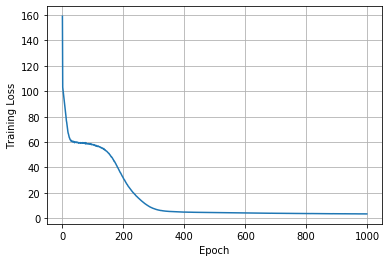

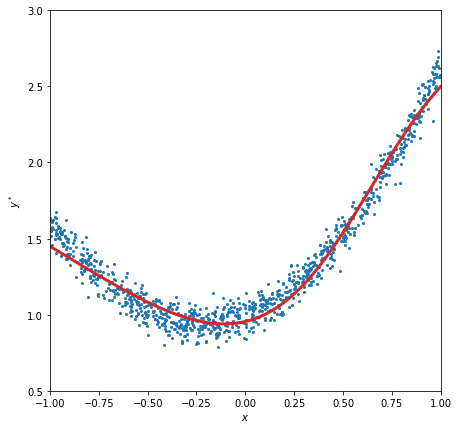

In [14]:
net = Neural_Network(n1=10)                                     # Create an instance of the Neural_Network class
train_network(net, batch_size=32, num_epochs=1000)              # Train the network
test_network(net)                                               # Test the network

## Exercise 1
Replace the sigmoid activation for a tanh activation and train the network.

In [6]:
class Neural_Network_tanh(Neural_Network):
    def __init__(self, n1=10):
        super().__init__(n1)
        
    def f1(self, q, compute_derivative=False):
        pass # Implement this function

In [7]:
# Implement the code to train the new network

## Exercise 2
Replace the sigmoid activation for a relu activation and train the network.

In [8]:
class Neural_Network_relu(Neural_Network):
    def __init__(self, n1=10):
        super().__init__(n1)
        
    def f1(self, q, compute_derivative=False):
        pass # Implement this code

In [9]:
# Implement the code to train the new network

## Exercise 3
Implement a neural network with two hidden layers and relu activation functions to fit the regression data.